In [16]:
import pandas as pd
import seaborn as sns; sns.set()
from ggplot import *
import numpy as np
import matplotlib.pyplot as plt
import os.path
import torch

In [17]:
"""organise_CSV import two CSV files and delete all duplicate row. Because the algorithme work with
    mini_batch there is many value for the loss for one epoch and one data set. We compute here the mean
    of all this loss that have the same epoch and data set. We did the same with the confusion matrix
    (0) = name_network : name of the network associated with the CSV file
    (1) = train_number : number of the network associated with the CSV file
"""
def organise_CSV(path_CSV,name_network,train_number):
    # Import the CSV file into pandas DataFrame
    loss_DF = pd.read_csv(path_CSV + "CSV_loss_" + name_network + str(train_number) + ".csv")
    # This Groupby will regroupe all line that have the same "Set" and "Epoch" and compute the mean over the "Values"
    loss_DF = loss_DF.groupby(['Set','Epoch'])['Value'].mean().reset_index()
    # Recreate the CSV file
    loss_DF.to_csv(path_CSV + "CSV_loss_" + name_network + str(train_number) + ".csv",index = False)
    
    # Import the CSV file into pandas DataFrame
    conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv")
    # This Groupby will regroupe all line that have the same 'Target','Prediction','Epoch','Set'
    # and compute the mean over the "Values"
    conf_DF = conf_DF.groupby(['Target','Prediction','Epoch','Set'])['Value'].mean().reset_index()
    # Recreate the CSV file
    conf_DF.to_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv",index = False)

In [18]:
"""plot_loss will plot the loss against the epoch
    (0) = name_network : name of the network associated with the CSV file
    (1) = train_number : number of the network associated with the CSV file
"""
def plot_loss(path_CSV,name_network,train_number):
    # Import the CSV file into pandas DataFrame
    loss_DF = pd.read_csv(path_CSV + "CSV_loss_" + name_network + str(train_number) + ".csv")
    
    # Epoch against Value with a different color for train and validation
    my_plot_loss = ggplot(aes(x="Epoch", y="Value",color = "Set"),data = loss_DF)
    my_plot_loss = my_plot_loss + geom_line() 
    my_plot_loss = my_plot_loss + ggtitle("Loss per epoch")
    my_plot_loss = my_plot_loss + ylab("Loss")
    print(my_plot_loss)

In [19]:
"""plot_IuO will plot the loss against the epoch
    (0) = name_network : name of the network associated with the CSV file
    (1) = train_number : number of the network associated with the CSV file
"""
def plot_IuO(path_CSV,name_network,train_number):
    # Import the CSV of the conv matrix
    conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv")
    
    # Delete the class 19
    conf_DF_uselfull_classes = conf_DF[(conf_DF["Prediction"] != "class"+str(parameters.number_classes - 1)) 
                                       & (conf_DF["Target"] != "class"+str(parameters.number_classes - 1))]
    # In the column "Value" there is the TP information
    conf_DF_TP = conf_DF_uselfull_classes[conf_DF_uselfull_classes["Prediction"] == conf_DF_uselfull_classes["Target"]]

    # In the column "Value" there is the FN information
    conf_DF_FN = conf_DF_uselfull_classes.groupby(["Set","Epoch","Target"])["Value"].sum().reset_index()
    # In the column "Value" there is the FP information
    conf_DF_FP = conf_DF_uselfull_classes.groupby(["Set","Epoch","Prediction"])["Value"].sum().reset_index()

    # Change the name
    conf_DF_FN.rename(columns={"Value": "FN"}, inplace=True)
    conf_DF_FP.rename(columns={"Value": "FP"}, inplace=True)

    # Merge the dataset together according to certain column
    conf_DF_TP_FN = conf_DF_TP.merge(conf_DF_FN, on=["Epoch","Set","Target"])
    conf_DF_TP_FN_FP = conf_DF_TP_FN.merge(conf_DF_FP, on=["Epoch","Set","Prediction"])
    
    # We compute the realFP and FN value, we have to substract the TP values
    conf_DF_TP_FN_FP["FP"] = conf_DF_TP_FN_FP["FP"] - conf_DF_TP_FN_FP["Value"]
    conf_DF_TP_FN_FP["FN"] = conf_DF_TP_FN_FP["FN"] - conf_DF_TP_FN_FP["Value"]
    
    # Compute the IoU each class
    conf_DF_TP_FN_FP["IoU"] = conf_DF_TP_FN_FP["Value"]/(conf_DF_TP_FN_FP["Value"] + 
                                                         conf_DF_TP_FN_FP["FP"] + conf_DF_TP_FN_FP["FN"])

    # Compute the mean IoU
    plot_DF = conf_DF_TP_FN_FP.groupby(["Set","Epoch"])["IoU"].mean().reset_index()

    #Add the real name of Data.
    
    # Plot the IuO mean
    my_plot_IoU = ggplot(aes(x="Epoch", y="IoU",color = "Set"),data = plot_DF) + geom_line()
    my_plot_IoU = my_plot_IoU + ggtitle("Mean IoU per epoch")
    my_plot_IoU = my_plot_IoU + ylab("Mean IoU")
    print(my_plot_IoU)
    
    #Change change the name of class for the plot
    conf_DF_TP_FN_FP = conf_DF_TP_FN_FP.merge(parameters.label_DF, left_on='Target', right_on='Class_name')

    # Plot the IuO per class only train
    my_plot_IoU = ggplot(aes(x="Epoch", y="IoU",color = "Real_name"),
                          data = conf_DF_TP_FN_FP[conf_DF_TP_FN_FP["Set"] == "train"]) + geom_line()
    my_plot_IoU = my_plot_IoU + ggtitle("Train IoU per epoch")
    my_plot_IoU = my_plot_IoU + ylab("Train IoU")
    print(my_plot_IoU)
    
    # Plot the IuO per class only validation
    my_plot_IoU = ggplot(aes(x="Epoch", y="IoU",color = "Real_name"),
                          data = conf_DF_TP_FN_FP[conf_DF_TP_FN_FP["Set"] == "validation"]) + geom_line()
    my_plot_IoU = my_plot_IoU + ggtitle("Validation IoU per epoch")
    my_plot_IoU = my_plot_IoU + ylab("Validation IoU")
    print(my_plot_IoU)

In [32]:
"""plot_IuO will plot confusion matrix
    (0) = name_network : name of the network associated with the CSV file
    (1) = train_number : number of the network associated with the CSV file
    (2) = epoch : Value of the epoch were we want to display the confusion matrix
    (3) = data_set : 
"""
def plot_mat_confusion(path_CSV,name_network,train_number,epoch,data_set):
    
    # Import the CSV as DataFrame
    conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv")
    # Select only the usefull epoch
    conf_DF = conf_DF[conf_DF["Epoch"]==epoch]
    # Keep only the DataSet to display
    conf_DF = conf_DF[conf_DF["Set"]==data_set]

    # Confusion Matrix
    conf_mat_for_plot = np.zeros((parameters.number_classes,parameters.number_classes))
    #Double loop over the confusion matrix the ad each value
    for i in range(parameters.number_classes):
        for j in range(parameters.number_classes):
            conf_mat_for_plot[i,j] = conf_DF.loc[(conf_DF["Prediction"]==("class"+str(i))) &
                                                 (conf_DF["Target"]==("class"+str(j))),"Value"].values
    
    #Just change column and row name to make good plot and make the confusion matrix a dataframe
    conf_mat_for_plot=pd.DataFrame(conf_mat_for_plot, columns = ["road","sidewalk","building","wall","fence",
                                                                        "pole","traffic light","traffic sign",
                                                                        "vegetation","terrain","sky","person","rider",
                                                                        "car","truck","bus","train","motorcycle",
                                                                        "bicycle"])
    # Rename the rows
    conf_mat_for_plot = conf_mat_for_plot.rename({0 : "road", 1 : "sidewalk", 2 : "building", 3 : "wall",4 : "fence",
                                                  5 : "pole",6 : "traffic light",7 : "traffic sign", 8 : "vegetation",
                                                  9 : "terrain",10 : "sky" ,11 : "person" ,12 : "rider", 13 :"car",
                                                  14 : "truck",15 : "bus",16 : "train",17 : "motorcycle",
                                                  18 : "bicycle"},axis='index')
    # Set the size
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    sns.heatmap(conf_mat_for_plot,annot=True,ax=ax,square = True,cmap = "Reds")
    plt.xlabel(r'Prediction',fontsize = 20)
    plt.ylabel(r'Real class',fontsize = 20)
    plt.title("Confusion matrix of " + data_set + "set for epoch " + str(epoch), fontsize = 20)
    plt.show()

In [33]:
class Parameters():
    def __init__(self,
                 # Number of columns of the grid
                 nColumns = 2,
                 # Number of features map at each rows
                 nFeatMaps = [3,6],
                 # Number of feature map of the input image
                 nFeatureMaps_init = 3,
                 #Number of classes (19(usefull classes) + 1(all other classes together))
                 number_classes = 20,
                 # DataFrame with the name of each label associated with their number
                 label_DF = None,

                 # Size of initial image
                 width_image_initial = 2048, height_image_initial = 1024,
                 # Size after the crop
                 width_image_crop = 19, height_image_crop = 19,

                 # Probability of a Blockwise dropout
                 dropFactor = 0.1,
                 learning_rate=0.01,
                 weight_decay = 5*10**(-6),
                 #Parameter of the Adam Optimizer (beta1 beta2 and epsilon)
                 beta1 = 0.9,
                 beta2 = 0.999,
                 epsilon = 1*10**(-8),
                 # Size of the mini batch
                 batch_size = 2,
                 # Size of the mini batch to compute error (if the entire validation set cannot be in loaded)
                 batch_size_val = 10,
                 # Maximum value of epoch iteration
                 epoch_total = 10,
                 # The actual epoch is not null if we train the network which has already been train
                 actual_epoch = 0,

                 # File where all the parameter model can be store
                 path_save_net = "Model/",
                 #Name of the network, used for store (name_network and train_number)
                 name_network = "test",
                 train_number = 0,
                 # File where the error will be stored
                 path_CSV = "CSV/",
                 # Path of the Data
                 path_data = "Cityscapes_Copy/",
                 # Number of process that will load the Data
                 num_workers = 0):
        
        super(Parameters, self).__init__()
        # Image
        self.number_classes = number_classes
        self.label_DF = label_DF
        self.width_image_initial = width_image_initial
        self.height_image_initial = height_image_initial
        self.width_image_crop = width_image_crop
        self.height_image_crop = height_image_crop
        # Number of feature map at the begining, if RGB image it would be 3
        self.nFeatureMaps_init = nFeatureMaps_init
        self.path_data = path_data
        
        # GridNet
        self.nColumns = nColumns
        self.nFeatMaps = nFeatMaps
        self.name_network = name_network
        self.train_number = train_number
        self.num_workers = num_workers
        
        #Save
        self.path_CSV = path_CSV
        self.path_save_net = path_save_net
        
        
        # Learning
        self.dropFactor = dropFactor
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.batch_size_val = batch_size_val
        self.epoch_total = epoch_total
        self.actual_epoch = actual_epoch

In [34]:
def load_from_checkpoint(path_checkpoint):
    if (os.path.isfile(path_checkpoint)):
        print("=> loading checkpoint '{}'".format(path_checkpoint))        
        checkpoint = torch.load(path_checkpoint)
        parameters = checkpoint['parameters']
        return(parameters)
    else:
        return("cocou")

path_checkpoint = "Model/best0test0checkpoint.pth.tar"

parameters = load_from_checkpoint(path_checkpoint)

=> loading checkpoint 'Model/best0test0checkpoint.pth.tar'


In [ ]:
organise_CSV(path_CSV = parameters.path_CSV,
             name_network = parameters.name_network,train_number = parameters.train_number)


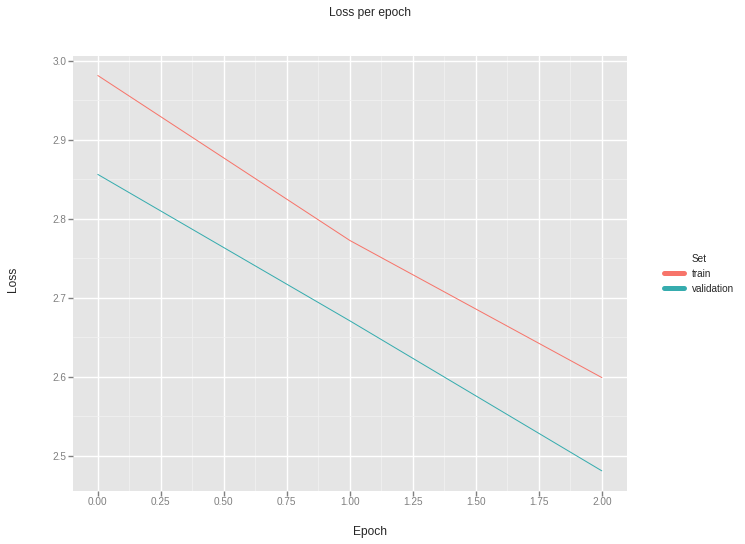

<ggplot: (-9223363304364334199)>


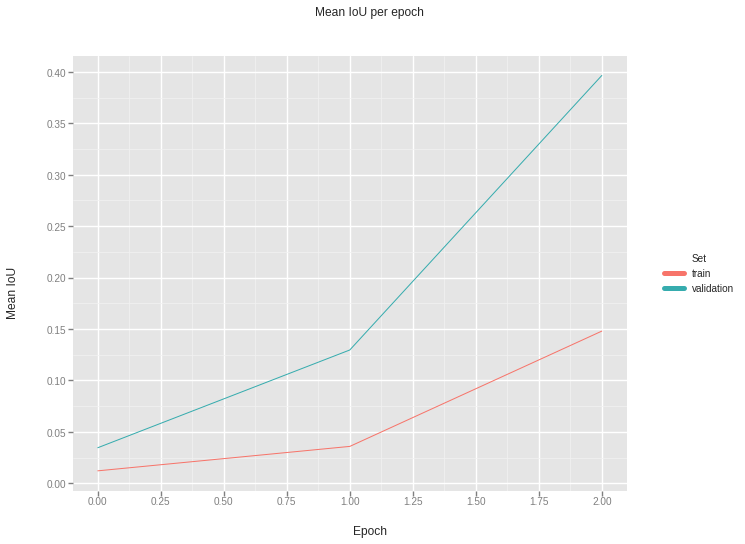

<ggplot: (-9223363304364566135)>


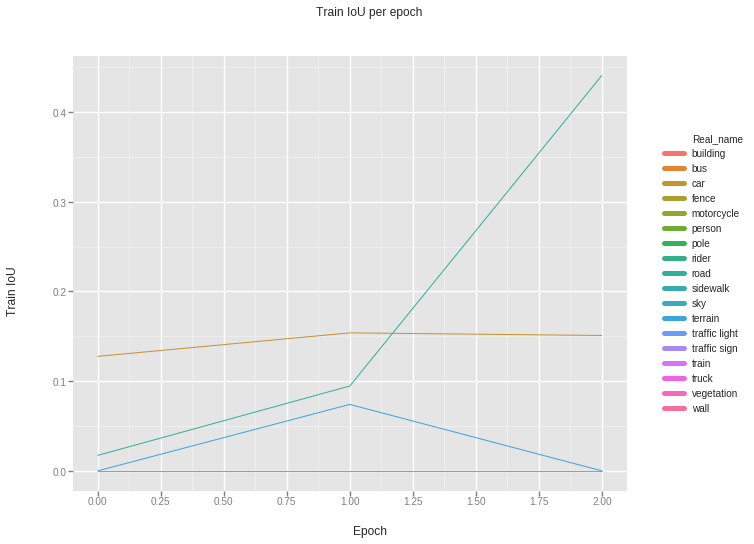

<ggplot: (-9223363304364743834)>


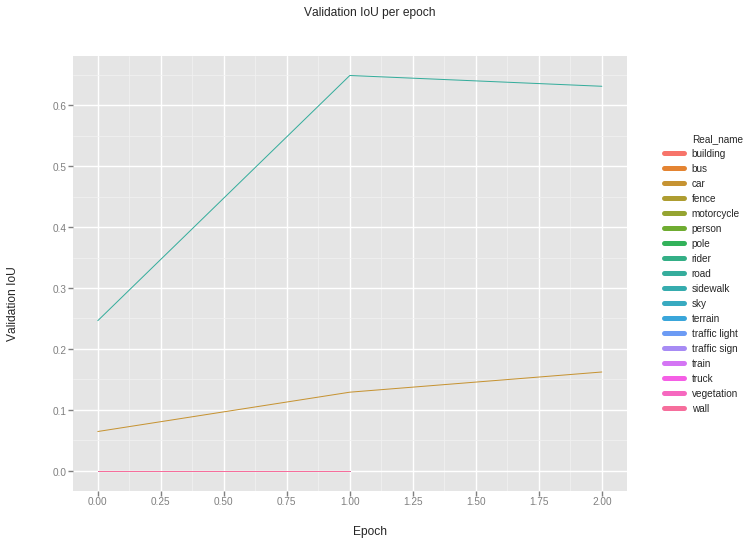

<ggplot: (8732490115290)>


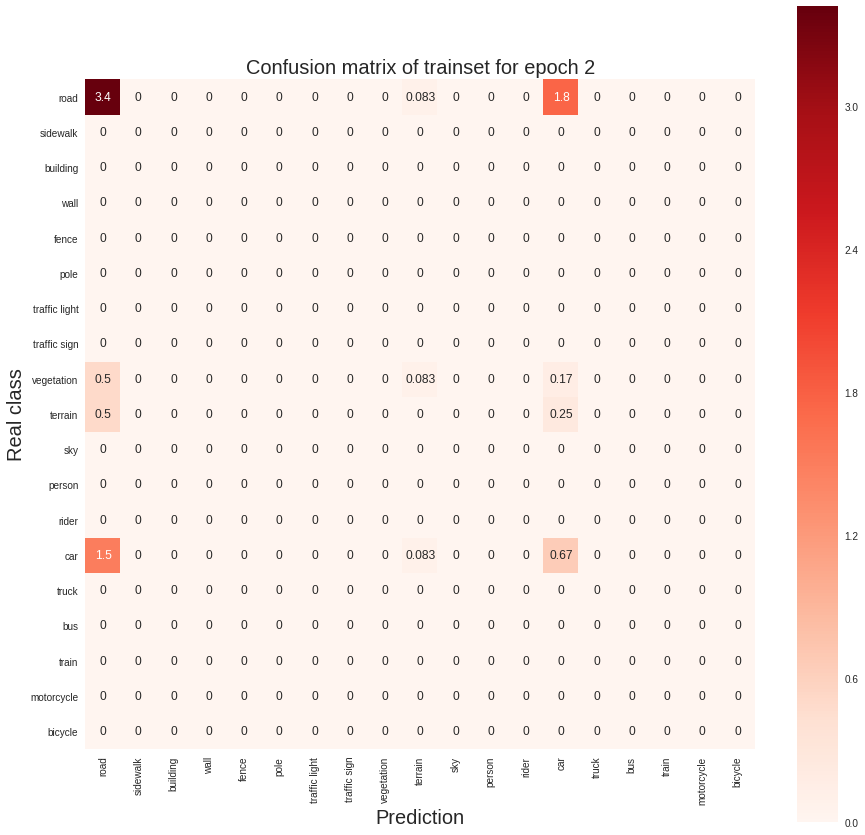

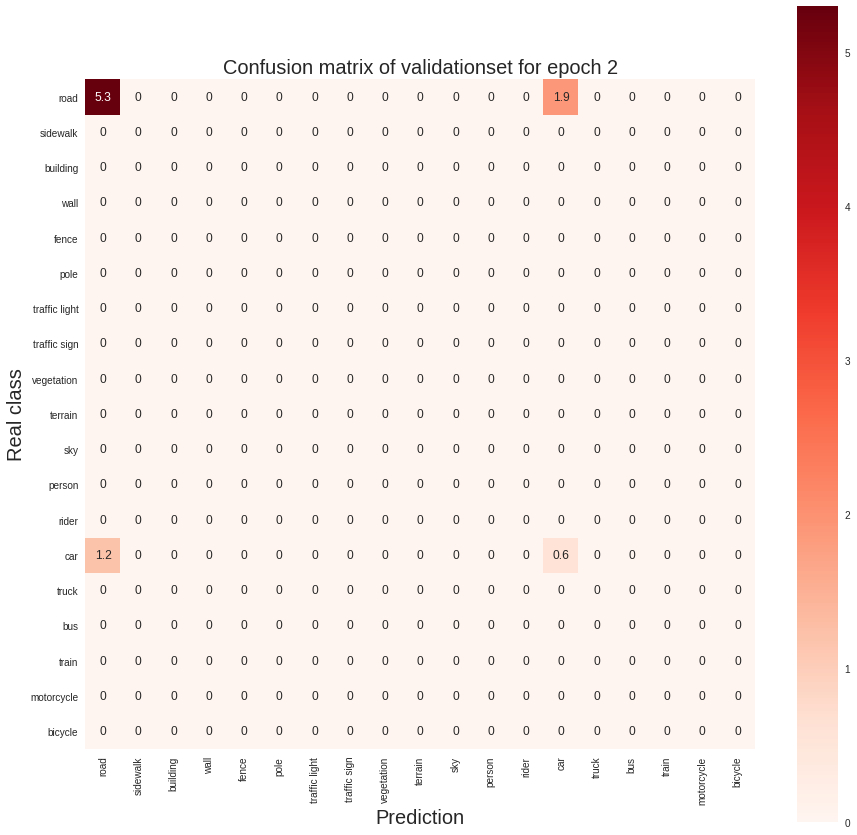

In [35]:
plot_loss(path_CSV = parameters.path_CSV,
         name_network = parameters.name_network,train_number = parameters.train_number)

plot_IuO(path_CSV = parameters.path_CSV,
         name_network = parameters.name_network,train_number = parameters.train_number)

plot_mat_confusion(path_CSV = parameters.path_CSV,
                   name_network = parameters.name_network, train_number = parameters.train_number,
                   epoch = parameters.epoch_total - 1, data_set = "train")

plot_mat_confusion(path_CSV = parameters.path_CSV,name_network = parameters.name_network,
                   train_number = parameters.train_number,
                   epoch = parameters.epoch_total - 1,data_set = "validation")